In [1]:
import numpy as np
from scipy import fftpack
import tensorly as tl
from util import square_tensor_gen, TensorInfoBucket, RandomInfoBucket, eval_mse, eval_rerr
from sketch import Sketch
import time
from tensorly.decomposition import tucker
from sketch_recover import SketchTwoPassRecover
from sketch_recover import SketchOnePassRecover
import matplotlib 
import matplotlib.pyplot as plt
from simulation import Simulation
plt.style.use('fivethirtyeight')
%matplotlib inline 

Using mxnet backend.
/Users/apple/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/apple/anaconda3/lib/python3.6/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL
Using numpy backend.


In [2]:
'''
n = 200
k = 12  
rank = 5 
dim = 3 
s = 80 
tensor_shape = np.repeat(n,dim)
noise_level = 0.01
gen_typ = 'id' 
Rinfo_bucket = RandomInfoBucket(random_seed = 1)

noise_levels = (np.float(10)**(np.arange(-10,2,2))) 
ho_svd_rerr = np.zeros(len(noise_levels))
two_pass_rerr = np.zeros(len(noise_levels))
one_pass_rerr = np.zeros(len(noise_levels))
one_pass_rerr_ns = np.zeros(len(noise_levels))

for idx, noise_level in enumerate(noise_levels): 
    print('Noise_level:', noise_level)
    simu = Simulation(tensor_shape, rank, k, s, Rinfo_bucket, gen_typ, noise_level)
    _, rerr = simu.ho_svd()
    #print('ho_svd rerr:', rerr) 
    ho_svd_rerr[idx] = rerr 

    _, rerr = simu.two_pass() 
    #print('two_pass:', rerr) 
    two_pass_rerr[idx] = rerr

    _, rerr = simu.one_pass()
    #print('one_pass:', rerr)
    one_pass_rerr[idx] = rerr

    _, rerr = simu.one_pass(store_phis = False) 
    one_pass_rerr_ns[idx]  = rerr


print("identity design with varying noise_level")
print("noise_levels", noise_levels)
print("ho_svd", ho_svd_rerr)
print("two_pass", two_pass_rerr)
print("one_pass", one_pass_rerr)
print("one_pass_ns", one_pass_rerr_ns)


plt.figure()
plt.plot(noise_levels,ho_svd_rerr,label = 'ho_svd') 
plt.title('ho_svd')
plt.plot(noise_levels,two_pass_rerr, label = 'two_pass')
plt.title('two_pass')
plt.plot(noise_levels,one_pass_rerr, label = 'one_pass') 
plt.title('one_pass')
plt.xscale('log')
plt.xscale('log')
plt.legend(loc = 'best')
plt.title('Relative Error, n = ')
plt.xlabel('Noise Level')
plt.ylabel('Relative Error')
plt.show()

'''

'\nn = 200\nk = 12  \nrank = 5 \ndim = 3 \ns = 80 \ntensor_shape = np.repeat(n,dim)\nnoise_level = 0.01\ngen_typ = \'id\' \nRinfo_bucket = RandomInfoBucket(random_seed = 1)\n\nnoise_levels = (np.float(10)**(np.arange(-10,2,2))) \nho_svd_rerr = np.zeros(len(noise_levels))\ntwo_pass_rerr = np.zeros(len(noise_levels))\none_pass_rerr = np.zeros(len(noise_levels))\none_pass_rerr_ns = np.zeros(len(noise_levels))\n\nfor idx, noise_level in enumerate(noise_levels): \n    print(\'Noise_level:\', noise_level)\n    simu = Simulation(tensor_shape, rank, k, s, Rinfo_bucket, gen_typ, noise_level)\n    _, rerr = simu.ho_svd()\n    #print(\'ho_svd rerr:\', rerr) \n    ho_svd_rerr[idx] = rerr \n\n    _, rerr = simu.two_pass() \n    #print(\'two_pass:\', rerr) \n    two_pass_rerr[idx] = rerr\n\n    _, rerr = simu.one_pass()\n    #print(\'one_pass:\', rerr)\n    one_pass_rerr[idx] = rerr\n\n    _, rerr = simu.one_pass(store_phis = False) \n    one_pass_rerr_ns[idx]  = rerr\n\n\nprint("identity design wit

In [3]:
gen_types = ['id', 'id1', 'id2', 'spd', 'fpd', 'sed', 'fed', 'lk']
rs = [1,5]
dim = 3

In [4]:
def plot_row(gen_type,r,noise_level,name, ns = np.arange(100,201,100), dim = 3, sim_runs = 1):
    plt.close()
    plt.figure(figsize = (len(ns)*5,5))
    for plot_id, n in enumerate(ns): 
        random_seed = np.random.randint(1000000) 
        ks =np.arange(r, int(n/2),int(n/20)) 
        ho_svd_rerr = np.zeros(len(ks))
        two_pass_rerr = np.zeros(len(ks))
        one_pass_rerr = np.zeros(len(ks))
        for idx, k in enumerate(ks): 
            simu = Simulation(np.repeat(n,dim), r, k, 2*k, RandomInfoBucket(random_seed), gen_type, noise_level)
            _, rerr = simu.ho_svd()
            ho_svd_rerr[idx] = rerr 
            _, rerr = simu.two_pass() 
            two_pass_rerr[idx] = rerr
            _, rerr = simu.one_pass()
            one_pass_rerr[idx] = rerr 
        print(ho_svd_rerr)
        print(two_pass_rerr)
        print(one_pass_rerr)
        plt.subplot(1,len(ns),plot_id+1) 
        plt.plot(ks/n,two_pass_rerr, label = 'two_pass')
        plt.title('two_pass')
        plt.plot(ks/n,one_pass_rerr, label = 'one_pass') 
        plt.title('one_pass') 
        plt.plot(ks/n,ho_svd_rerr, label = 'hosvd') 
        plt.title('hosvd') 
        plt.legend(loc = 'best')
        plt.title("n = %s"%(n))
        plt.xlabel('k/n')
        plt.ylabel('Relative Error')
        plt.axis('equal')
        xmin, xmax = plt.xlim()  
        plt.xlim((0, xmax))  
        ymin, ymax = plt.ylim()  
        plt.ylim((ymin, ymax))   
    plt.tight_layout()
    plt.savefig('plots/'+name)
    plt.show()

Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.


[0.09999924 0.09994475 0.09988992 0.10001987 0.09990731 0.09995296
 0.09996694 0.09997642 0.09993519]
[0.56049802 0.18117477 0.1549821  0.13854759 0.12549948 0.11933748
 0.11715772 0.11011171 0.10982364]
[0.85373144 0.33573073 0.19908966 0.16838001 0.1479913  0.13187383
 0.12724118 0.12606274 0.11892819]


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy b

[0.10000433 0.09999978 0.0999825  0.09994563 0.0999606  0.09995685
 0.09994917 0.09994488 0.10000493 0.10001884]
[0.52821998 0.16082438 0.13096282 0.11849173 0.11442835 0.11044564
 0.10815504 0.10693124 0.10514858 0.10436955]
[0.87132232 0.19808222 0.15326463 0.13300342 0.12575567 0.12210508
 0.11593333 0.11251043 0.11081632 0.1077716 ]


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy b

[0.10000688 0.10000952 0.09999467 0.09997476 0.0999871  0.09997779
 0.10000327 0.09999681 0.10001368 0.09998101]
[0.63253039 0.13527253 0.1193683  0.11277931 0.10917389 0.10731564
 0.10569686 0.10475615 0.10339195 0.10298449]
[0.64479524 0.16685038 0.14153804 0.12538157 0.11776502 0.11353599
 0.11089699 0.10906827 0.10692555 0.10576128]


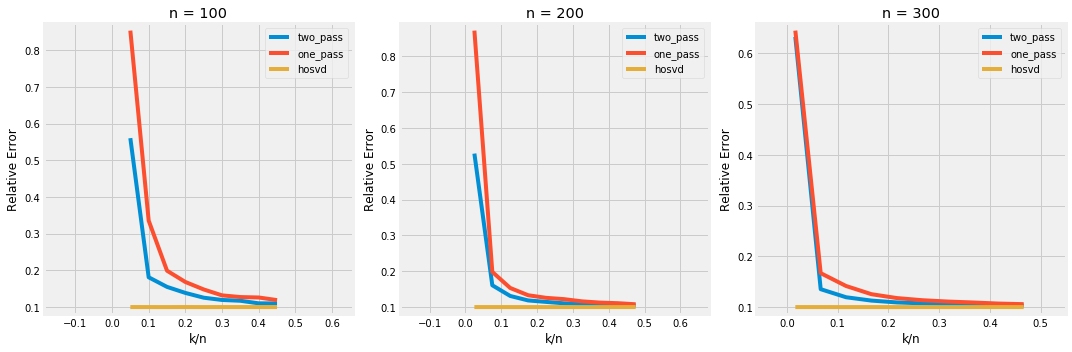

In [13]:
plot_row('id',5,0.01,"id_lnoise.pdf",ns = np.arange(100,301,100), sim_runs = 1)

Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.


[1.25064263e-15 7.90871218e-16 1.25284575e-15 1.77203120e-15
 1.26199384e-15 1.41026212e-15 9.66286292e-16 1.09379586e-15
 1.07168012e-15]
[7.50932518e-16 9.78457803e-16 9.33840040e-16 1.24356093e-15
 1.49526092e-15 1.17891871e-15 9.94046679e-16 7.55748226e-16
 1.56842534e-15]
[1.27281230e-15 2.12637138e-15 3.54520088e-15 3.46920577e-15
 3.06935412e-15 2.80371907e-15 3.86175876e-15 3.69571261e-15
 3.85569879e-15]


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy b

[1.29199408e-15 1.28640035e-15 1.06484361e-15 9.45237651e-16
 7.22020556e-16 8.71328063e-16 7.81142406e-16 1.19645058e-15
 1.45347610e-15 9.11905469e-16]
[1.02207517e-15 1.08793145e-15 1.48669886e-15 1.69903101e-15
 1.48399894e-15 1.41089233e-15 9.98344798e-16 9.81819200e-16
 1.43264718e-15 1.14083452e-15]
[1.36215150e-15 2.38546800e-15 3.28134574e-15 4.71754981e-15
 3.50248779e-15 3.64765964e-15 4.20659504e-15 4.38522854e-15
 4.58096397e-15 4.58674997e-15]


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy b

[6.34771500e-16 1.31997406e-15 7.92969235e-16 7.89052607e-16
 1.29603409e-15 1.21401549e-15 9.40715047e-16 1.04751602e-15
 1.09947397e-15 1.21352704e-15]
[9.44096479e-16 8.62162602e-16 1.68394810e-15 1.37605091e-15
 9.98645959e-16 1.04006203e-15 1.61909681e-15 1.12405268e-15
 1.33400353e-15 1.16720907e-15]
[1.50664223e-15 3.02247454e-15 3.97541169e-15 4.65587443e-15
 4.11201396e-15 4.07820219e-15 4.46588291e-15 4.37087716e-15
 4.62705004e-15 5.03548941e-15]


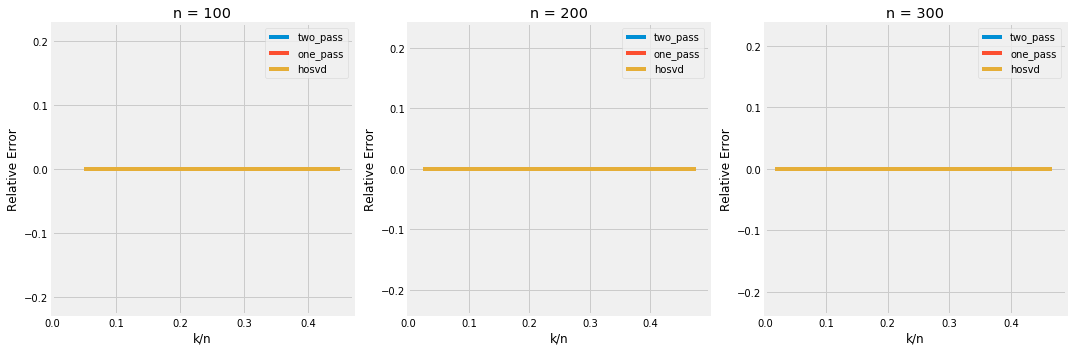

In [6]:
plot_row('id',5,0,"id_nonoise.pdf",ns = np.arange(100,301,100), sim_runs = 1)

Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.


[0.99931293 1.00179221 0.99927123 0.99920157 0.99951832 0.99943787
 0.99900713 0.99993442 0.99727413]
[1.39256636 1.33124652 1.26775531 1.20189595 1.16771346 1.14716252
 1.13758953 1.10329302 1.07444241]
[1.9957268  1.89934261 1.51339071 1.49010521 1.32688851 1.26485162
 1.23013032 1.20709269 1.1694843 ]


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy b

[0.99976563 1.00000275 0.99959722 0.99993878 0.99962954 0.99999412
 0.99904293 1.00015671 0.99957863 0.99970796]
[1.39356495 1.2914926  1.19898345 1.15240487 1.10022307 1.09277608
 1.06939225 1.06341093 1.04740057 1.0415669 ]
[2.27149102 1.57327619 1.39159812 1.27257373 1.21659035 1.18079229
 1.12815343 1.12000675 1.08331709 1.07769707]


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy b

[1.00004394 1.00009287 0.99996044 0.99995189 1.00000055 0.99999086
 0.99988008 0.99986819 0.99983017 0.99986119]
[1.38637944 1.24393937 1.15279923 1.1168315  1.07778594 1.06420738
 1.04901463 1.04021909 1.03167248 1.02891566]
[2.59074391 1.48793637 1.28866283 1.20055669 1.17044194 1.12761637
 1.09566249 1.08434318 1.06263369 1.05328122]


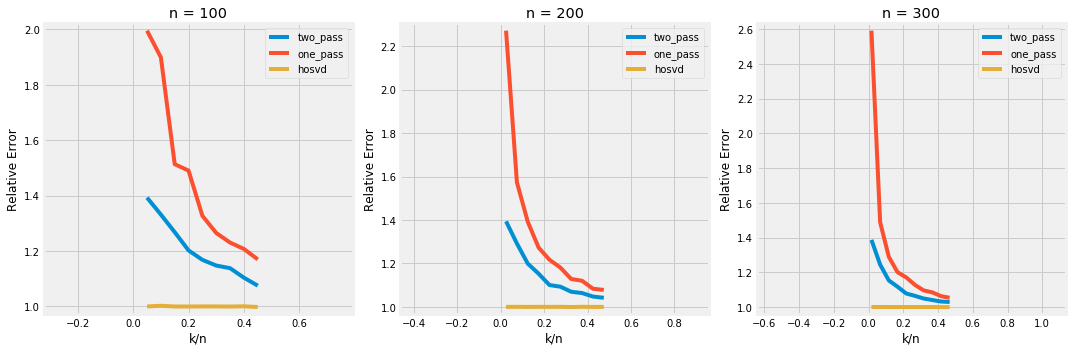

In [7]:
plot_row('id',5,1,"id_hnoise.pdf",ns = np.arange(100,301,100), sim_runs = 1)

Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy b

[0.09992974 0.09983899 0.10002465 0.09992366 0.10006201 0.09993627
 0.09996326 0.10000035 0.10004969 0.10013341]
[0.98818124 0.11584089 0.11665534 0.10871358 0.10592741 0.10558378
 0.10286292 0.1029407  0.10186938 0.10155795]
[0.64748355 0.147075   0.12183111 0.1139968  0.10982097 0.10919461
 0.10656501 0.10627388 0.10455336 0.10324171]


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy b

[0.09996546 0.10000746 0.09997023 0.10001767 0.09991958 0.09997768
 0.10002691 0.10002923 0.10002935 0.10001481]
[0.1955704  0.11449136 0.1070143  0.10581794 0.1024155  0.10199828
 0.10176401 0.10147809 0.10095265 0.10094123]
[0.72367322 0.11562994 0.11447299 0.10749732 0.1064429  0.10579817
 0.10294684 0.1023834  0.10216767 0.10166416]


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy b

[0.09999942 0.09999244 0.10003674 0.10000591 0.1000036  0.09999472
 0.09999928 0.10000122 0.09999249 0.1000006 ]
[0.20155915 0.1141368  0.10396178 0.1035112  0.10209768 0.10179325
 0.10136633 0.10104983 0.10072127 0.10066202]
[0.34581822 0.11434239 0.10702653 0.10515493 0.10422207 0.10304286
 0.10237043 0.10177493 0.10151471 0.10141827]


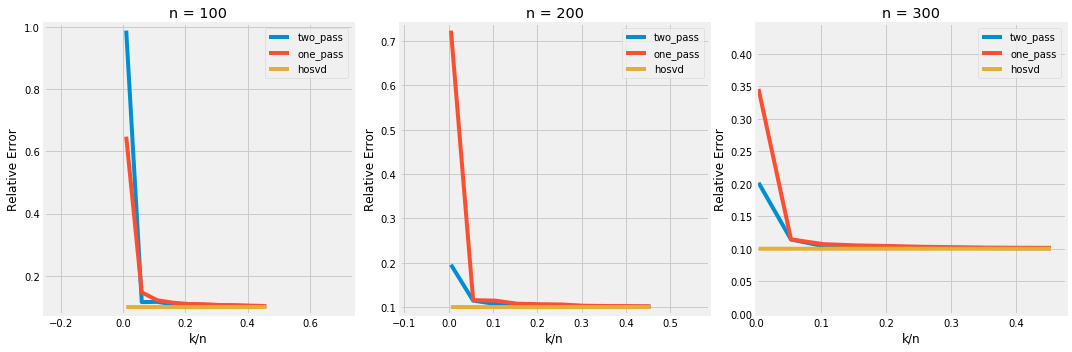

In [8]:
plot_row('id',1,0.01,"id_rk1.pdf",ns = np.arange(100,301,100), sim_runs = 1)

Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.


[0.33559063 0.33559063 0.4957095  0.4957095  0.33559063 0.33559063
 0.33559063 0.4957095  0.33559063]
[0.82987666 0.45764549 0.39756017 0.36532569 0.35593368 0.34753425
 0.34219294 0.3415045  0.33893485]
[0.99789261 0.72924327 0.43454646 0.3947604  0.37056895 0.36353804
 0.34923863 0.34490628 0.34333708]


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy b

[0.33682461 0.33682461 0.33682461 0.33682461 0.49642038 0.33682461
 0.33682461 0.33682461 0.33682461 0.33682461]
[0.82194999 0.39119972 0.35689082 0.34613999 0.34200384 0.34011229
 0.33851078 0.33831748 0.33771005 0.33756598]
[1.15152012 0.47731522 0.37549975 0.35102499 0.34631596 0.3428051
 0.34081878 0.33929729 0.33855783 0.33808265]


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy b

[0.33722476 0.33722476 0.33722476 0.33722476 0.33722476 0.33722476
 0.33722476 0.33722476 0.33722476 0.33722476]
[0.83668156 0.38625247 0.34785505 0.34137192 0.33928152 0.33850761
 0.33804815 0.33781182 0.33767788 0.33753916]
[1.53487351 0.39891838 0.35543325 0.34535691 0.34123792 0.33978765
 0.33893834 0.33840226 0.33807139 0.33788321]


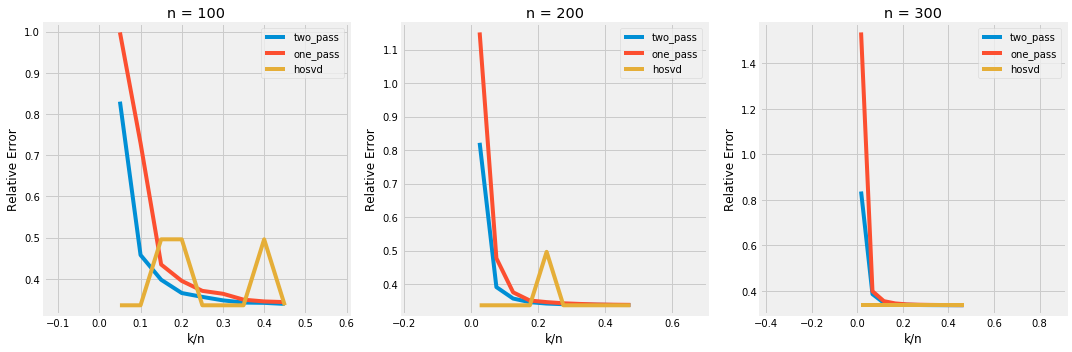

In [9]:
plot_row('spd',5,0.01,"spd.pdf",ns = np.arange(100,301,100), sim_runs = 1)

Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.


[0.1272709 0.1272709 0.1272709 0.1272709 0.1272709 0.1272709 0.1272709
 0.1272709 0.1272709]
[0.610786   0.14994689 0.12872537 0.1275726  0.12733213 0.12731019
 0.12729751 0.12727868 0.12727553]
[0.73570412 0.19625325 0.13198111 0.12776435 0.12752826 0.12733683
 0.12730568 0.12728474 0.12728454]


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy b

[0.12727115 0.12727115 0.12727115 0.12727115 0.12727115 0.12727115
 0.12727115 0.12727115 0.12727115 0.12727115]
[0.50485761 0.12887777 0.12736517 0.12729057 0.12727671 0.12727398
 0.12727271 0.12727193 0.1272716  0.12727139]
[0.74492792 0.13027638 0.12747528 0.12731027 0.12728226 0.1272767
 0.12727366 0.12727261 0.1272719  0.12727158]


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy b

[0.12727117 0.12727117 0.12727117 0.12727117 0.12727117 0.12727117
 0.12727117 0.12727117 0.12727117 0.12727117]
[0.48110563 0.12752087 0.12729623 0.12727529 0.1272723  0.12727164
 0.12727143 0.1272713  0.12727124 0.12727122]
[0.56503237 0.12770302 0.12730177 0.12727942 0.1272738  0.12727227
 0.12727167 0.12727143 0.12727131 0.12727127]


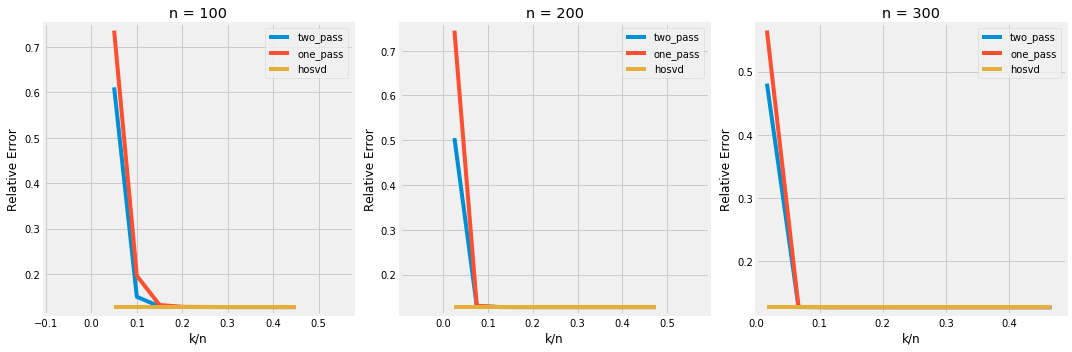

In [10]:
plot_row('fpd',5,0.01,"fpd.pdf",ns = np.arange(100,301,100), sim_runs = 1)

Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.


[0.16857724 0.16857724 0.16857724 0.16857724 0.16857724 0.16857724
 0.16857724 0.16857724 0.16857724]
[0.54396194 0.17280917 0.16859947 0.16857728 0.16857724 0.16857724
 0.16857724 0.16857724 0.16857724]
[0.71815075 0.17380669 0.16859444 0.16857731 0.16857724 0.16857724
 0.16857724 0.16857724 0.16857724]


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy b

[0.16857724 0.16857724 0.16857724 0.16857724 0.16857724 0.16857724
 0.16857724 0.16857724 0.16857724 0.16857724]
[0.63878727 0.16858848 0.16857724 0.16857724 0.16857724 0.16857724
 0.16857724 0.16857724 0.16857724 0.16857724]
[0.88895048 0.16860777 0.16857724 0.16857724 0.16857724 0.16857724
 0.16857724 0.16857724 0.16857724 0.16857724]


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy b

[0.45089133 0.16857724 0.16857724 0.16857724 0.16857724 0.16857724
 0.16857724 0.16857724 0.16857724 0.16857724]
[0.71930279 0.16857727 0.16857724 0.16857724 0.16857724 0.16857724
 0.16857724 0.16857724 0.16857724 0.16857724]
[0.88506593 0.1685774  0.16857724 0.16857724 0.16857724 0.16857724
 0.16857724 0.16857724 0.16857724 0.16857724]


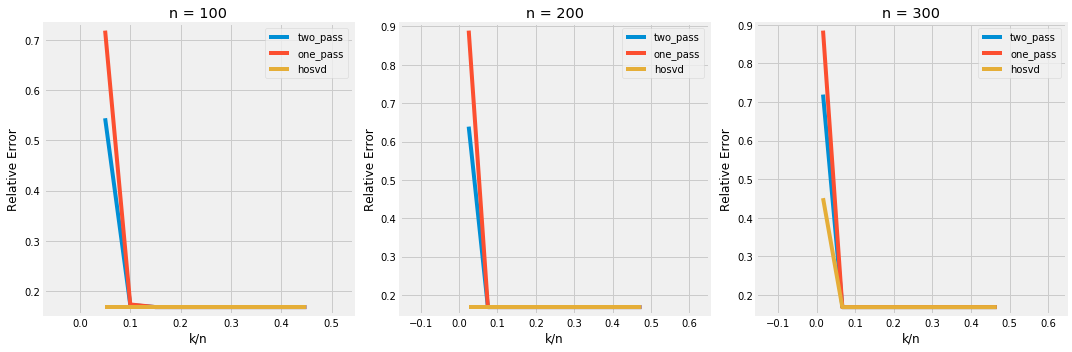

In [11]:
plot_row('sed',5,0.01,"sed.pdf",ns = np.arange(100,301,100), sim_runs = 1)

Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.


[0.00449462 0.00449462 0.00449462 0.00449462 0.00449462 0.00449462
 0.00449462 0.00449462 0.00449462]
[0.07394186 0.00449462 0.00449462 0.00449462 0.00449462 0.00449462
 0.00449462 0.00449462 0.00449462]
[0.20971236 0.00449462 0.00449462 0.00449462 0.00449462 0.00449462
 0.00449462 0.00449462 0.00449462]


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy b

[0.00449462 0.00449462 0.00449462 0.00449462 0.00449462 0.00449462
 0.00449462 0.00449462 0.00449462 0.00449462]
[0.01530703 0.00449462 0.00449462 0.00449462 0.00449462 0.00449462
 0.00449462 0.00449462 0.00449462 0.00449462]
[0.03131761 0.00449462 0.00449462 0.00449462 0.00449462 0.00449462
 0.00449462 0.00449462 0.00449462 0.00449462]


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy b

[0.00449462 0.00449462 0.00449462 0.00449462 0.00449462 0.00449462
 0.00449462 0.00449462 0.00449462 0.00449462]
[0.09851536 0.00449462 0.00449462 0.00449462 0.00449462 0.00449462
 0.00449462 0.00449462 0.00449462 0.00449462]
[0.06893843 0.00449462 0.00449462 0.00449462 0.00449462 0.00449462
 0.00449462 0.00449462 0.00449462 0.00449462]


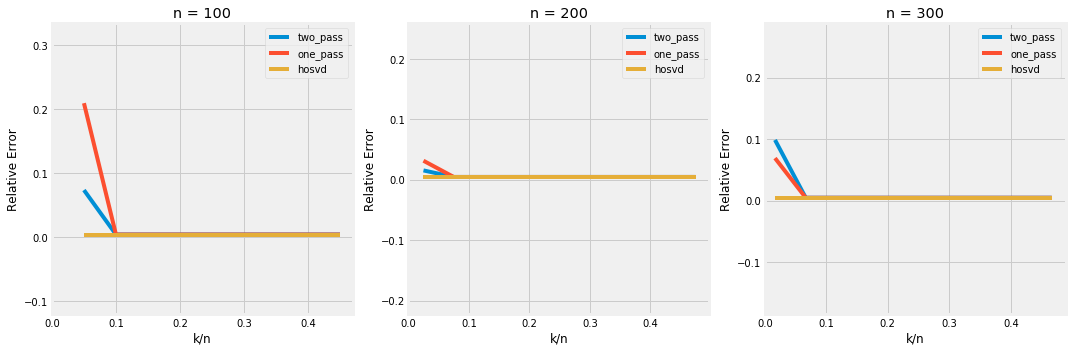

In [12]:
plot_row('fed',5,0.01,"fed.pdf",ns = np.arange(100,301,100), sim_runs = 1)